# Анализ лояльности пользователей Яндекс Афиши

## Этапы выполнения проекта

### 1. Загрузка данных и их предобработка

---

**Задача 1.1:** Напишите SQL-запрос, выгружающий в датафрейм pandas необходимые данные. Используйте следующие параметры для подключения к базе данных `data-analyst-afisha`:

Для выгрузки используйте запрос из предыдущего урока и библиотеку SQLAlchemy.

Выгрузка из базы данных SQL должна позволить собрать следующие данные:

- `user_id` — уникальный идентификатор пользователя, совершившего заказ;
- `device_type_canonical` — тип устройства, с которого был оформлен заказ (`mobile` — мобильные устройства, `desktop` — стационарные);
- `order_id` — уникальный идентификатор заказа;
- `order_dt` — дата создания заказа (используйте данные `created_dt_msk`);
- `order_ts` — дата и время создания заказа (используйте данные `created_ts_msk`);
- `currency_code` — валюта оплаты;
- `revenue` — выручка от заказа;
- `tickets_count` — количество купленных билетов;
- `days_since_prev` — количество дней от предыдущей покупки пользователя, для пользователей с одной покупкой — значение пропущено;
- `event_id` — уникальный идентификатор мероприятия;
- `service_name` — название билетного оператора;
- `event_type_main` — основной тип мероприятия (театральная постановка, концерт и так далее);
- `region_name` — название региона, в котором прошло мероприятие;
- `city_name` — название города, в котором прошло мероприятие.

---


In [1]:
!pip install phik

In [2]:
import pandas as pd
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import seaborn as sns
from phik import phik_matrix

In [3]:
db_config = {'user': 'praktikum_student', # имя пользователя
             'pwd': 'Sdf4$2;d-d30pp', # пароль
             'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
             'port': 6432, # порт подключения
             'db': 'data-analyst-afisha' # название базы данных
             }

connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)

In [4]:
engine = create_engine(connection_string)
query = '''
SELECT user_id,
       device_type_canonical,
       order_id,
       created_dt_msk AS order_dt,
       created_ts_msk AS order_ts,
       currency_code,
       revenue,
       tickets_count,
       created_dt_msk::date - 
       LAG(created_dt_msk::date)OVER(PARTITION BY user_id ORDER BY created_dt_msk::date) AS          days_since_prev,
       events.event_id AS event_id,
       event_name_code AS event_name,
       event_type_main,
       service_name,
       region_name,
       city_name
FROM afisha.purchases
JOIN afisha.events ON purchases.event_id = events.event_id
JOIN afisha.city ON events.city_id = city.city_id
JOIN afisha.regions ON city.region_id = regions.region_id
WHERE device_type_canonical IN ('mobile', 'desktop')  AND event_type_main != 'фильм'
ORDER BY user_id
'''
df = pd.read_sql_query(query, con=engine)

---

**Задача 1.2:** Изучите общую информацию о выгруженных данных. Оцените корректность выгрузки и объём полученных данных.

Предположите, какие шаги необходимо сделать на стадии предобработки данных — например, скорректировать типы данных.

Зафиксируйте основную информацию о данных в кратком промежуточном выводе.

---

In [5]:
print(df.info())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290611 entries, 0 to 290610
Data columns (total 15 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   user_id                290611 non-null  object        
 1   device_type_canonical  290611 non-null  object        
 2   order_id               290611 non-null  int64         
 3   order_dt               290611 non-null  datetime64[ns]
 4   order_ts               290611 non-null  datetime64[ns]
 5   currency_code          290611 non-null  object        
 6   revenue                290611 non-null  float64       
 7   tickets_count          290611 non-null  int64         
 8   days_since_prev        268678 non-null  float64       
 9   event_id               290611 non-null  int64         
 10  event_name             290611 non-null  object        
 11  event_type_main        290611 non-null  object        
 12  service_name           290611 non-null  obje

Всего представлены данные на 33.3 МБ. Присутствуют пропуски в столбце days_since_prev

Необходимо выяснить причину прорусков, преобразования типов данных не требуется

---

###  2. Предобработка данных

Выполните все стандартные действия по предобработке данных:

---

**Задача 2.1:** Данные о выручке сервиса представлены в российских рублях и казахстанских тенге. Приведите выручку к единой валюте — российскому рублю.

Для этого используйте датасет с информацией о курсе казахстанского тенге по отношению к российскому рублю за 2024 год — `final_tickets_tenge_df.csv`. Его можно загрузить по пути `https://code.s3.yandex.net/datasets/final_tickets_tenge_df.csv')`

Значения в рублях представлено для 100 тенге.

Результаты преобразования сохраните в новый столбец `revenue_rub`.

---


In [6]:
tenge_rate = pd.read_csv('https://code.s3.yandex.net/datasets/final_tickets_tenge_df.csv')
tenge_rate['order_dt'] = pd.to_datetime(tenge_rate['data'])

In [7]:
df = df.merge(tenge_rate[['order_dt', 'curs']], how = 'inner', on = 'order_dt')

Объединяем датафреймы

In [8]:
df['curs'] = (df['revenue'] * df['curs'])/100

In [9]:
df.loc[df['currency_code'] == 'rub', 'curs'] = df.loc[df['currency_code'] == 'rub', 'revenue']

Игнорирование цен в рублях

In [10]:
df = df.rename(columns={'curs': 'revenue_rub'})

---

**Задача 2.2:**

- Проверьте данные на пропущенные значения. Если выгрузка из SQL была успешной, то пропуски должны быть только в столбце `days_since_prev`.
- Преобразуйте типы данных в некоторых столбцах, если это необходимо. Обратите внимание на данные с датой и временем, а также на числовые данные, размерность которых можно сократить.
- Изучите значения в ключевых столбцах. Обработайте ошибки, если обнаружите их.
    - Проверьте, какие категории указаны в столбцах с номинальными данными. Есть ли среди категорий такие, что обозначают пропуски в данных или отсутствие информации? Проведите нормализацию данных, если это необходимо.
    - Проверьте распределение численных данных и наличие в них выбросов. Для этого используйте статистические показатели, гистограммы распределения значений или диаграммы размаха.
        
        Важные показатели в рамках поставленной задачи — это выручка с заказа (`revenue_rub`) и количество билетов в заказе (`tickets_count`), поэтому в первую очередь проверьте данные в этих столбцах.
        
        Если обнаружите выбросы в поле `revenue_rub`, то отфильтруйте значения по 99 перцентилю.

После предобработки проверьте, были ли отфильтрованы данные. Если были, то оцените, в каком объёме. Сформулируйте промежуточный вывод, зафиксировав основные действия и описания новых столбцов.

---

In [11]:
print(df.isna().sum())

user_id                      0
device_type_canonical        0
order_id                     0
order_dt                     0
order_ts                     0
currency_code                0
revenue                      0
tickets_count                0
days_since_prev          21933
event_id                     0
event_name                   0
event_type_main              0
service_name                 0
region_name                  0
city_name                    0
revenue_rub                  0
dtype: int64


In [12]:
for column in ['device_type_canonical',
               'currency_code',
               'event_type_main',
               'service_name',
               'region_name',
               'city_name']:
    print(df[column].unique())

['mobile' 'desktop']
['rub' 'kzt']
['театр' 'концерты' 'другое' 'стендап' 'выставки' 'ёлки' 'спорт']
['Край билетов' 'Билеты без проблем' 'Лучшие билеты' 'Мой билет' 'Яблоко'
 'Лови билет!' 'Show_ticket' 'Билеты в руки' 'Дом культуры'
 'Весь в билетах' 'Облачко' 'Быстробилет' 'Восьмёрка' 'Мир касс'
 'Прачечная' 'Городской дом культуры' 'За билетом!' 'Выступления.ру'
 'Тебе билет!' 'Росбилет' 'Crazy ticket!' 'Вперёд!' 'Кино билет'
 'Радио ticket' 'Зе Бест!' 'Телебилет' 'Шоу начинается!'
 'Билет по телефону' 'КарандашРУ' 'Быстрый кассир' 'Реестр' 'Дырокол'
 'Тех билет' 'Лимоны' 'Билеты в интернете' 'Цвет и билет']
['Каменевский регион' 'Боровлянский край' 'Широковская область'
 'Травиницкий округ' 'Речиновская область' 'Североярская область'
 'Травяная область' 'Солнечноземская область' 'Светополянский округ'
 'Дальнеземская область' 'Тепляковская область'
 'Солнечнореченская область' 'Зеленоградский округ' 'Яблоневская область'
 'Озернинский край' 'Малиновоярский округ' 'Ветренский реги

Пропуски отсутствуют

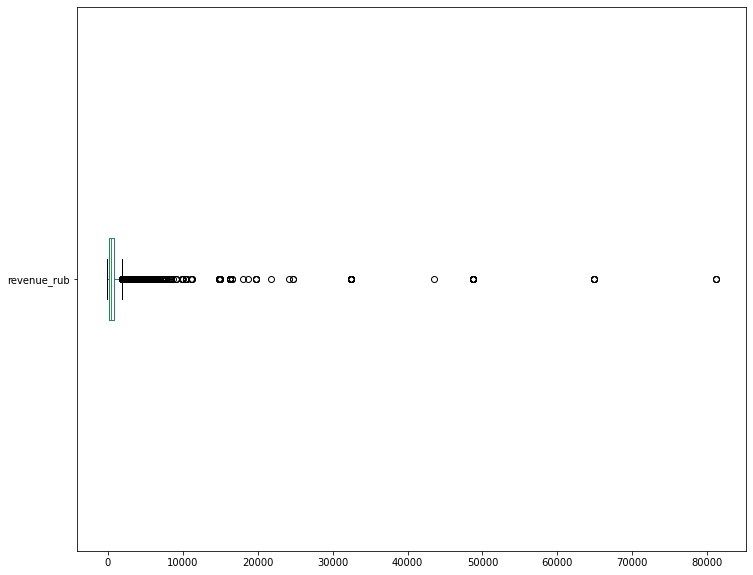

In [13]:
boxplot1 = df.boxplot(column='revenue_rub',
                      grid=False,
                      vert=False,
                      figsize=(12, 10))


plt.show()

Присутстувуют значительные выбросы

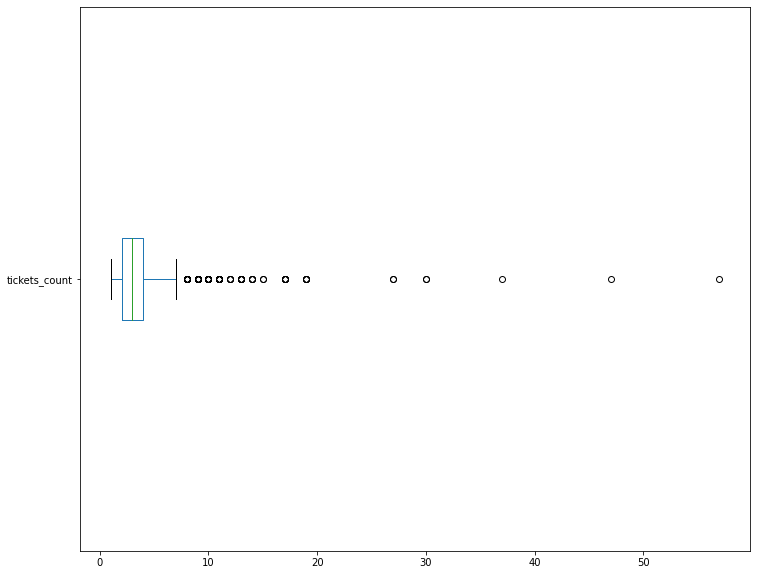

In [14]:
boxplot2 = df.boxplot(column='tickets_count',
                      grid=False,
                      vert=False,
                      figsize=(12, 10))

plt.show()

Присутствуют незначительные выбросы

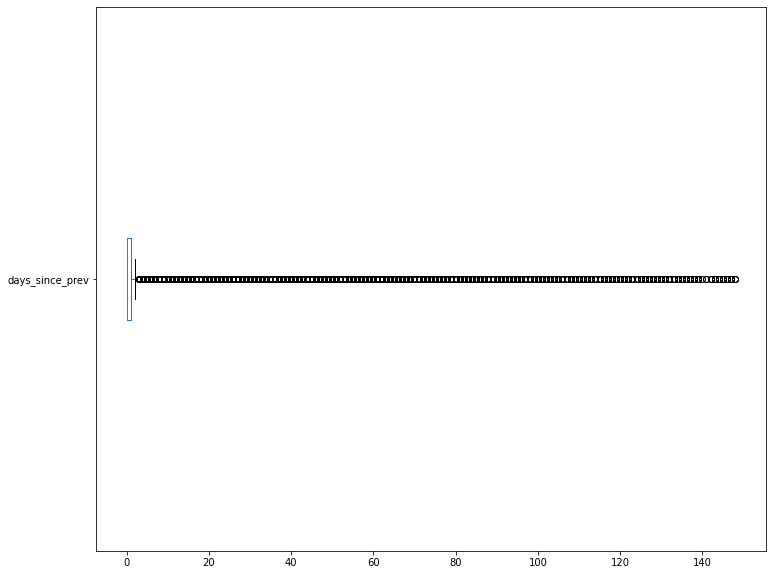

In [15]:
boxplot3 = df.boxplot(column='days_since_prev',
                      grid=False,
                      vert=False,
                      figsize=(12, 10))

plt.show()

In [16]:
x = df['revenue_rub'].describe(percentiles = [0.99])
df = df.loc[df['revenue_rub'] <= x['99%']]

Фильтрация по 99 процентилю

---

### 3. Создание профиля пользователя

В будущем отдел маркетинга планирует создать модель для прогнозирования возврата пользователей. Поэтому сейчас они просят вас построить агрегированные признаки, описывающие поведение и профиль каждого пользователя.

---

**Задача 3.1.** Постройте профиль пользователя — для каждого пользователя найдите:

- дату первого и последнего заказа;
- устройство, с которого был сделан первый заказ;
- регион, в котором был сделан первый заказ;
- билетного партнёра, к которому обращались при первом заказе;
- жанр первого посещённого мероприятия (используйте поле `event_type_main`);
- общее количество заказов;
- средняя выручка с одного заказа в рублях;
- среднее количество билетов в заказе;
- среднее время между заказами.

После этого добавьте два бинарных признака:

- `is_two` — совершил ли пользователь 2 и более заказа;
- `is_five` — совершил ли пользователь 5 и более заказов.

**Рекомендация:** перед тем как строить профиль, отсортируйте данные по времени совершения заказа.

---


In [17]:
df.sort_values(by = ['user_id', 'order_ts'], ascending = True, inplace = True)

In [18]:
df_agg = df.groupby('user_id').agg({'order_ts':'min',
                                    'order_dt':'count',
                                    'revenue_rub':'mean',
                                    'tickets_count':'mean',
                                    'days_since_prev':'mean'
                                    })

df_agg['qqq'] = df.groupby('user_id')['order_ts'].max()
print(df_agg.head())

                           order_ts  order_dt  revenue_rub  tickets_count  \
user_id                                                                     
0002849b70a3ce2 2024-08-20 16:08:03         1  1521.940000       4.000000   
0005ca5e93f2cf4 2024-07-23 18:36:24         2   774.010000       3.000000   
000898990054619 2024-07-13 19:40:48         3   767.213333       2.666667   
00096d1f542ab2b 2024-08-15 16:48:48         1   917.830000       4.000000   
000a55a418c128c 2024-09-29 19:39:12         2    61.310000       1.500000   

                 days_since_prev                 qqq  
user_id                                               
0002849b70a3ce2              NaN 2024-08-20 16:08:03  
0005ca5e93f2cf4             75.0 2024-10-06 13:56:02  
000898990054619             51.0 2024-10-23 15:12:00  
00096d1f542ab2b              NaN 2024-08-15 16:48:48  
000a55a418c128c             16.0 2024-10-15 10:29:04  


In [19]:
df_agg.rename(columns={"order_ts": "order_ts_min",
                       "order_dt": "total_orders",
                       "revenue_rub": "revenue_rub_avg",
                       "tickets_count": "tickets_count_avg",
                       "days_since_prev": "days_since_prev_avg",
                       "qqq": "order_ts_max"
                      },
             inplace = True
             )


In [20]:
df_agg = df_agg.merge(df[['region_name',
                         'device_type_canonical',
                         'service_name',
                         'event_type_main',
                         'user_id',
                         'order_ts']],
                      how = 'inner',
                      left_on = ['user_id', 'order_ts_min'],
                      right_on = ['user_id', 'order_ts']
                     )

df_agg = df_agg[['user_id', 'order_ts_min', 'total_orders', 'revenue_rub_avg',
                 'tickets_count_avg', 'days_since_prev_avg', 'order_ts_max',
                 'region_name', 'device_type_canonical', 'service_name',
                 'event_type_main'
                ]]


In [21]:
print(df_agg.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21854 entries, 0 to 21853
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   user_id                21854 non-null  object        
 1   order_ts_min           21854 non-null  datetime64[ns]
 2   total_orders           21854 non-null  int64         
 3   revenue_rub_avg        21854 non-null  float64       
 4   tickets_count_avg      21854 non-null  float64       
 5   days_since_prev_avg    13516 non-null  float64       
 6   order_ts_max           21854 non-null  datetime64[ns]
 7   region_name            21854 non-null  object        
 8   device_type_canonical  21854 non-null  object        
 9   service_name           21854 non-null  object        
 10  event_type_main        21854 non-null  object        
dtypes: datetime64[ns](2), float64(3), int64(1), object(5)
memory usage: 2.0+ MB
None


In [22]:
def is_two(x):
    if x >= 2:
        return 1
    else:
        return 0

def is_five(x):
    if x >= 5:
        return 1
    else:
        return 0
    
df_agg['is_two'] = df_agg['total_orders'].apply(is_two)
df_agg['is_five'] = df_agg['total_orders'].apply(is_five)

print(df_agg.head(10))

           user_id        order_ts_min  total_orders  revenue_rub_avg  \
0  0002849b70a3ce2 2024-08-20 16:08:03             1      1521.940000   
1  0005ca5e93f2cf4 2024-07-23 18:36:24             2       774.010000   
2  000898990054619 2024-07-13 19:40:48             3       767.213333   
3  00096d1f542ab2b 2024-08-15 16:48:48             1       917.830000   
4  000a55a418c128c 2024-09-29 19:39:12             2        61.310000   
5  000cf0659a9f40f 2024-06-20 10:35:26            13      1175.808462   
6  00147c9209d45d3 2024-06-25 23:26:58             2       352.945000   
7  0018ecd8a38a51b 2024-07-25 20:38:57             1         0.000000   
8  00199a573901564 2024-06-17 22:58:15             1       588.120000   
9  001e7037d013f0f 2024-07-04 08:06:44             3       326.623333   

   tickets_count_avg  days_since_prev_avg        order_ts_max  \
0           4.000000                  NaN 2024-08-20 16:08:03   
1           3.000000            75.000000 2024-10-06 13:56:02   
2

---

**Задача 3.2.** Прежде чем проводить исследовательский анализ данных и делать выводы, важно понять, с какими данными вы работаете: насколько они репрезентативны и нет ли в них аномалий.

Используя данные о профилях пользователей, рассчитайте:

- общее число пользователей в выборке;
- среднюю выручку с одного заказа;
- долю пользователей, совершивших 2 и более заказа;
- долю пользователей, совершивших 5 и более заказов.

Также изучите статистические показатели:

- по общему числу заказов;
- по среднему числу билетов в заказе;
- по среднему количеству дней между покупками.

По результатам оцените данные: достаточно ли их по объёму, есть ли аномальные значения в данных о количестве заказов и среднем количестве билетов?

Если вы найдёте аномальные значения, опишите их и примите обоснованное решение о том, как с ними поступить:

- Оставить и учитывать их при анализе?
- Отфильтровать данные по какому-то значению, например, по 95-му или 99-му перцентилю?

Если вы проведёте фильтрацию, то вычислите объём отфильтрованных данных и выведите статистические показатели по обновлённому датасету.

In [24]:
print(f'Всего пользователей:{df_agg.shape[0]}.')
print(f"Средняя выручка:{df_agg['revenue_rub_avg'].mean()}")
print(f"Доля пользователей, совершивших 2 и более заказа:{df_agg['is_two'].mean()}")
print(f"Доля пользователей, совершивших 5 и более заказов:{df_agg['is_five'].mean()}")

Всего пользователей:21854.
Средняя выручка:544.398050897431
Доля пользователей, совершивших 2 и более заказа:0.6170952686007138
Доля пользователей, совершивших 5 и более заказов:0.2900613160062231


In [26]:
print(f"Всего заказов:{df_agg['total_orders'].sum()}")
print(f"Среднее количество билетов в заказе:{df_agg['tickets_count_avg'].mean()}")
print(f"Среднее количество дней между покупками:{df_agg['days_since_prev_avg'].mean()}")

Всего заказов:287786
Среднее количество билетов в заказе:2.74312898863352
Среднее количество дней между покупками:15.836792789630076


In [27]:
print(df_agg.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21854 entries, 0 to 21853
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   user_id                21854 non-null  object        
 1   order_ts_min           21854 non-null  datetime64[ns]
 2   total_orders           21854 non-null  int64         
 3   revenue_rub_avg        21854 non-null  float64       
 4   tickets_count_avg      21854 non-null  float64       
 5   days_since_prev_avg    13516 non-null  float64       
 6   order_ts_max           21854 non-null  datetime64[ns]
 7   region_name            21854 non-null  object        
 8   device_type_canonical  21854 non-null  object        
 9   service_name           21854 non-null  object        
 10  event_type_main        21854 non-null  object        
 11  is_two                 21854 non-null  int64         
 12  is_five                21854 non-null  int64         
dtypes

In [28]:
df_agg['days_since_prev_avg'] = df_agg['days_since_prev_avg'].fillna(-1)

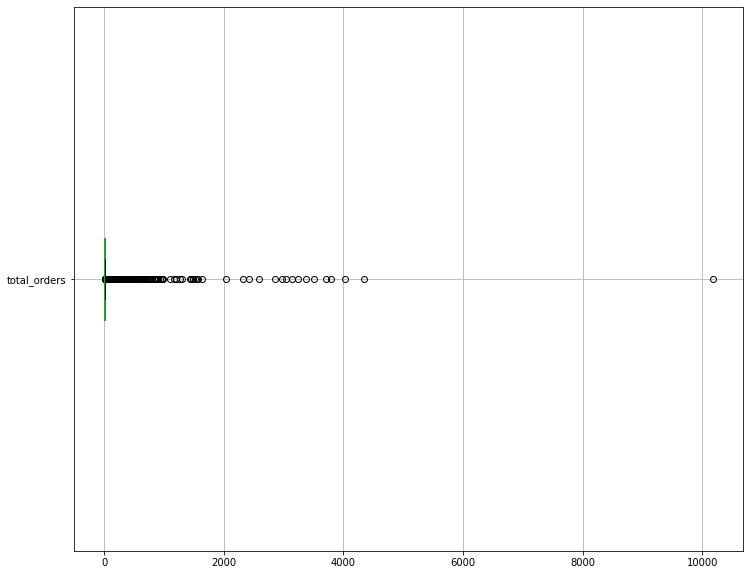

In [29]:
boxplot = df_agg.boxplot(column='total_orders',
                         vert=False, 
                         figsize=(12, 10))
plt.show()

Присутствуют значительные выбросы.

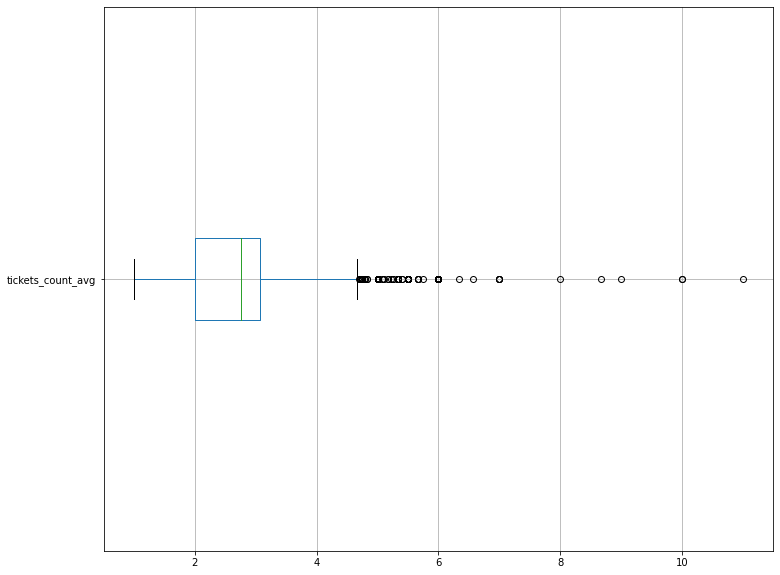

In [30]:
boxplot = df_agg.boxplot(column='tickets_count_avg',
                         vert=False, 
                         figsize=(12, 10))
plt.show()

Фильтрация по билетам не требуется

In [31]:
x = df_agg['total_orders'].describe(percentiles = [0.99])
df_agg = df_agg.loc[df_agg['total_orders'] <= x['99%']]

фильтрация по 99 процентилю

In [32]:
print(df_agg.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21638 entries, 0 to 21853
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   user_id                21638 non-null  object        
 1   order_ts_min           21638 non-null  datetime64[ns]
 2   total_orders           21638 non-null  int64         
 3   revenue_rub_avg        21638 non-null  float64       
 4   tickets_count_avg      21638 non-null  float64       
 5   days_since_prev_avg    21638 non-null  float64       
 6   order_ts_max           21638 non-null  datetime64[ns]
 7   region_name            21638 non-null  object        
 8   device_type_canonical  21638 non-null  object        
 9   service_name           21638 non-null  object        
 10  event_type_main        21638 non-null  object        
 11  is_two                 21638 non-null  int64         
 12  is_five                21638 non-null  int64         
dtypes

Всего удаленно 216 строчек

---

### 4. Исследовательский анализ данных

Следующий этап — исследование признаков, влияющих на возврат пользователей, то есть на совершение повторного заказа. Для этого используйте профили пользователей.



#### 4.1. Исследование признаков первого заказа и их связи с возвращением на платформу

Исследуйте признаки, описывающие первый заказ пользователя, и выясните, влияют ли они на вероятность возвращения пользователя.

---

**Задача 4.1.1.** Изучите распределение пользователей по признакам.

- Сгруппируйте пользователей:
    - по типу их первого мероприятия;
    - по типу устройства, с которого совершена первая покупка;
    - по региону проведения мероприятия из первого заказа;
    - по билетному оператору, продавшему билеты на первый заказ.
- Подсчитайте общее количество пользователей в каждом сегменте и их долю в разрезе каждого признака. Сегмент — это группа пользователей, объединённых определённым признаком, то есть объединённые принадлежностью к категории. Например, все клиенты, сделавшие первый заказ с мобильного телефона, — это сегмент.
- Ответьте на вопрос: равномерно ли распределены пользователи по сегментам или есть выраженные «точки входа» — сегменты с наибольшим числом пользователей?

---


In [33]:
event_name = df_agg.groupby('event_type_main').agg({'user_id':'count'})
device_name = df_agg.groupby('device_type_canonical').agg({'user_id':'count'})
region_name = df_agg.groupby('region_name').agg({'user_id':'count'})
service_name = df_agg.groupby('service_name').agg({'user_id':'count'})
total_users = df_agg.shape[0]


In [34]:
event_name['propotion'] = event_name/total_users
device_name['propotion'] = device_name/total_users
region_name['propotion'] = region_name/total_users
service_name['propotion'] = service_name/total_users

event_name = event_name.sort_values(by = 'user_id', ascending = False)
device_name = device_name.sort_values(by = 'user_id', ascending = False)
region_name = region_name.sort_values(by = 'user_id', ascending = False)
service_name = service_name.sort_values(by = 'user_id', ascending = False)

region_name = region_name.head(10)
service_name = service_name.head(10)


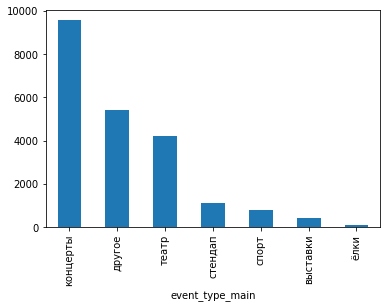

In [39]:
event_name['user_id'].plot.bar()
plt.show()

Сильный разброс по данным. Концерты - сегмент с наибольшим числом пользователей

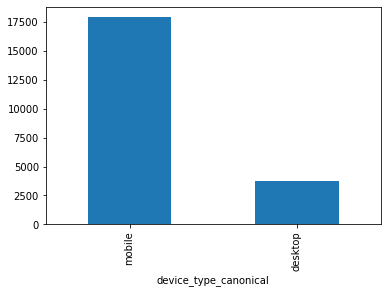

In [36]:
device_name['user_id'].plot.bar()
plt.show()

Сильный разброс по данным. Mobile - сегмент с наибольшим числом пользователей

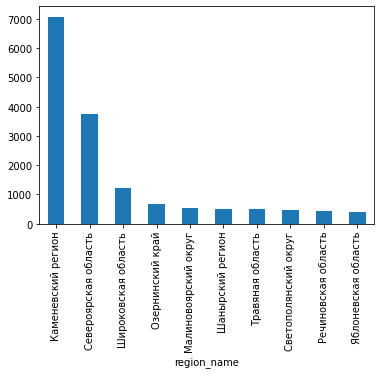

In [37]:
region_name['user_id'].plot.bar()
plt.show()

Сильный разброс по данным. Каменевский - сегмент с наибольшим числом пользователей

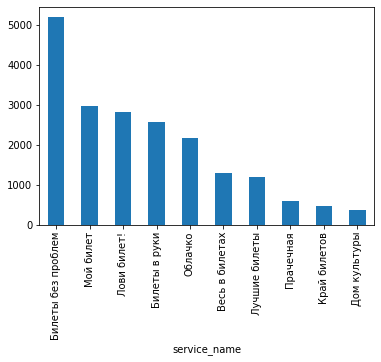

In [38]:
service_name['user_id'].plot.bar()
plt.show()

Сильный разброс по данным. "Билеты без проблем" - сегмент с наибольшим числом пользователей

---

**Задача 4.1.2.** Проанализируйте возвраты пользователей:

- Для каждого сегмента вычислите долю пользователей, совершивших два и более заказа.
- Визуализируйте результат подходящим графиком. Если сегментов слишком много, то поместите на график только 10 сегментов с наибольшим количеством пользователей. Такое возможно с сегментами по региону и по билетному оператору.
- Ответьте на вопросы:
    - Какие сегменты пользователей чаще возвращаются на Яндекс Афишу?
    - Наблюдаются ли успешные «точки входа» — такие сегменты, в которых пользователи чаще совершают повторный заказ, чем в среднем по выборке?

При интерпретации результатов учитывайте размер сегментов: если в сегменте мало пользователей (например, десятки), то доли могут быть нестабильными и недостоверными, то есть показывать широкую вариацию значений.

---


In [40]:
event_name_is_two = df_agg.groupby('event_type_main').agg({'is_two':'mean'})
device_name_is_two = df_agg.groupby('device_type_canonical').agg({'is_two':'mean'})
region_name_is_two = df_agg.groupby('region_name').agg({'is_two':'mean'})
service_name_is_two = df_agg.groupby('service_name').agg({'is_two':'mean'})

In [41]:
event_name_is_two = event_name_is_two.sort_values(by = 'is_two', ascending = False)
device_name_is_two = device_name_is_two.sort_values(by = 'is_two', ascending = False)
region_name_is_two = region_name_is_two.sort_values(by = 'is_two', ascending = False)
service_name_is_two = service_name_is_two.sort_values(by = 'is_two', ascending = False)

region_name_is_two = region_name_is_two.head(10)
service_name_is_two = service_name_is_two.head(10)

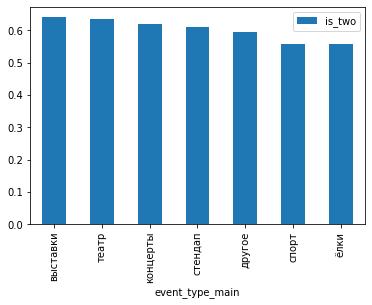

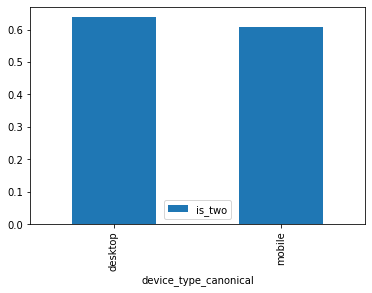

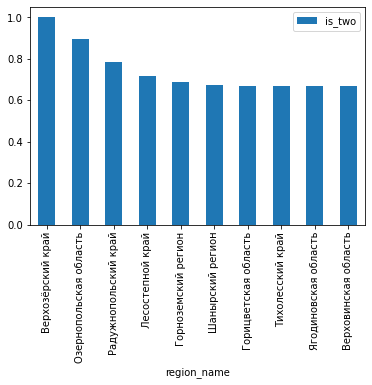

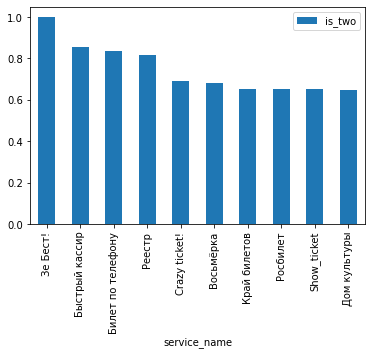

In [42]:
event_name_is_two.plot.bar()
device_name_is_two.plot.bar()
region_name_is_two.plot.bar()
service_name_is_two.plot.bar()

plt.show()

Чаще всего пользователи совершают повторную покупку в Верхозёрском крае в сервисе "Зе Бест!"

---

**Задача 4.1.3.** Опираясь на выводы из задач выше, проверьте продуктовые гипотезы:

- **Гипотеза 1.** Тип мероприятия влияет на вероятность возврата на Яндекс Афишу: пользователи, которые совершили первый заказ на спортивные мероприятия, совершают повторный заказ чаще, чем пользователи, оформившие свой первый заказ на концерты.
- **Гипотеза 2.** В регионах, где больше всего пользователей посещают мероприятия, выше доля повторных заказов, чем в менее активных регионах.

---

Доля пользователей совершивших повторную покупку распределены равномернно по типу мероприятия

Каменевский район и Североярская область лидируют по общему количеству покупок, но не лидируют по доля повторных покупок

---

#### 4.2. Исследование поведения пользователей через показатели выручки и состава заказа

Изучите количественные характеристики заказов пользователей, чтобы узнать среднюю выручку сервиса с заказа и количество билетов, которое пользователи обычно покупают.

Эти метрики важны не только для оценки выручки, но и для оценки вовлечённости пользователей. Возможно, пользователи с более крупными и дорогими заказами более заинтересованы в сервисе и поэтому чаще возвращаются.

---

**Задача 4.2.1.** Проследите связь между средней выручкой сервиса с заказа и повторными заказами.

- Постройте сравнительные гистограммы распределения средней выручки с билета (`avg_revenue_rub`):
    - для пользователей, совершивших один заказ;
    - для вернувшихся пользователей, совершивших 2 и более заказа.
- Ответьте на вопросы:
    - В каких диапазонах средней выручки концентрируются пользователи из каждой группы?
    - Есть ли различия между группами?

Текст на сером фоне:
    
**Рекомендация:**

1. Используйте одинаковые интервалы (`bins`) и прозрачность (`alpha`), чтобы визуально сопоставить распределения.
2. Задайте параметру `density` значение `True`, чтобы сравнивать форму распределений, даже если число пользователей в группах отличается.

---


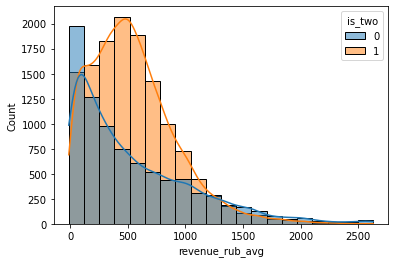

In [44]:
sns.histplot(data = df_agg,x = 'revenue_rub_avg', bins = 20, kde = True, hue = 'is_two')

plt.show()

Единичные заказы совершаются на сумму до 100 руб. Повторные на сумму 500 руб.

---

**Задача 4.2.2.** Сравните распределение по средней выручке с заказа в двух группах пользователей:

- совершившие 2–4 заказа;
- совершившие 5 и более заказов.

Ответьте на вопрос: есть ли различия по значению средней выручки с заказа между пользователями этих двух групп?

---


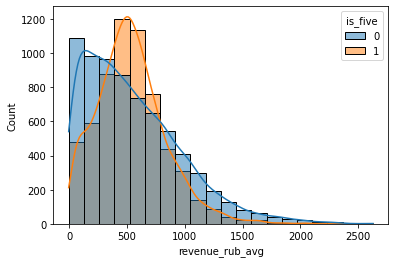

In [45]:
sns.histplot(data = df_agg[df_agg['is_two'] != 0],
             x = 'revenue_rub_avg', bins = 20, kde = True, hue = 'is_five')

plt.show()

Соввершиышие 5 и более заказов в среднем тратят по 500-600 руб.

---

**Задача 4.2.3.** Проанализируйте влияние среднего количества билетов в заказе на вероятность повторной покупки.

- Изучите распределение пользователей по среднему количеству билетов в заказе (`avg_tickets_count`) и опишите основные наблюдения.
- Разделите пользователей на несколько сегментов по среднему количеству билетов в заказе:
    - от 1 до 2 билетов;
    - от 2 до 3 билетов;
    - от 3 до 5 билетов;
    - от 5 и более билетов.
- Для каждого сегмента подсчитайте общее число пользователей и долю пользователей, совершивших повторные заказы.
- Ответьте на вопросы:
    - Как распределены пользователи по сегментам — равномерно или сконцентрировано?
    - Есть ли сегменты с аномально высокой или низкой долей повторных покупок?

---

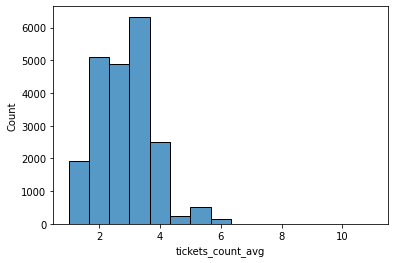

In [46]:
sns.histplot(data = df_agg, x = 'tickets_count_avg', bins = 15)

plt.show()

Обычно покупают от 2 до 4 билетов

In [47]:
def category(x):
    if x >= 1 and x < 2:
        return 12
    elif x >= 2 and x < 3:
        return 23
    elif x >= 3 and x < 5:
        return 35
    else:
        return 5

df_agg['category'] = df_agg['tickets_count_avg'].apply(category)

In [48]:
category_agg = df_agg.groupby('category')['user_id'].count()
category_agg_is_two = df_agg.groupby('category')['is_two'].mean()

category_agg = category_agg.sort_values(ascending = False)
category_agg_is_two = category_agg_is_two.sort_values(ascending = False)

print(category_agg)
print(category_agg_is_two)

category
23    9498
35    9060
12    2419
5      661
Name: user_id, dtype: int64
category
23    0.735839
35    0.542605
12    0.513022
5     0.187595
Name: is_two, dtype: float64


Больше всего покупателей из категории 2-3 и 3-5. 73 процента из категории 2-3 сделали повторную покупку

---

#### 4.3. Исследование временных характеристик первого заказа и их влияния на повторные покупки

Изучите временные параметры, связанные с первым заказом пользователей:

- день недели первой покупки;
- время с момента первой покупки — лайфтайм;
- средний интервал между покупками пользователей с повторными заказами.

---

**Задача 4.3.1.** Проанализируйте, как день недели, в которой была совершена первая покупка, влияет на поведение пользователей.

- По данным даты первого заказа выделите день недели.
- Для каждого дня недели подсчитайте общее число пользователей и долю пользователей, совершивших повторные заказы. Результаты визуализируйте.
- Ответьте на вопрос: влияет ли день недели, в которую совершена первая покупка, на вероятность возврата клиента?

---


In [49]:
df_agg['day_of_week'] = df_agg['order_ts_min'].dt.dayofweek

In [50]:
day_of_week_agg = df_agg.groupby('day_of_week')['user_id'].count()
day_of_week_agg_is_two = df_agg.groupby('day_of_week')['is_two'].mean()

day_of_week_agg = day_of_week_agg.sort_values(ascending = False)
day_of_week_agg_is_two = day_of_week_agg_is_two.sort_values(ascending = False)

print(day_of_week_agg)
print(day_of_week_agg_is_two)



day_of_week
5    3326
4    3259
1    3176
3    3113
2    3057
0    2930
6    2777
Name: user_id, dtype: int64
day_of_week
0    0.630375
5    0.628082
2    0.621851
1    0.619018
6    0.600288
4    0.598343
3    0.594282
Name: is_two, dtype: float64


Больше всего покупают билетов в воскресенье. Доля повторных покупок распределенна равномерно 

---

**Задача 4.3.2.** Изучите, как средний интервал между заказами влияет на удержание клиентов.

- Рассчитайте среднее время между заказами для двух групп пользователей:
    - совершившие 2–4 заказа;
    - совершившие 5 и более заказов.
- Исследуйте, как средний интервал между заказами влияет на вероятность повторного заказа, и сделайте выводы.

---


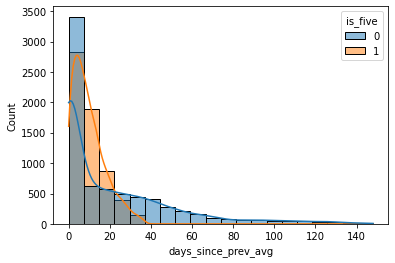

In [54]:
sns.histplot(data = df_agg.loc[(df_agg['is_two'] != 0) & (df_agg['days_since_prev_avg'] != -1)],
             x = 'days_since_prev_avg', bins = 20, kde = True, hue = 'is_five')

plt.show()

Пользователи совершают покупки с интервалом в неделю.

---

#### 4.4. Корреляционный анализ количества покупок и признаков пользователя

Изучите, какие характеристики первого заказа и профиля пользователя могут быть связаны с числом покупок. Для этого используйте универсальный коэффициент корреляции `phi_k`, который позволяет анализировать как числовые, так и категориальные признаки.

---

**Задача 4.4.1:** Проведите корреляционный анализ:
- Рассчитайте коэффициент корреляции `phi_k` между признаками профиля пользователя и числом заказов (`total_orders`). При необходимости используйте параметр `interval_cols` для определения интервальных данных.
- Проанализируйте полученные результаты. Если полученные значения будут близки к нулю, проверьте разброс данных в `total_orders`. Такое возможно, когда в данных преобладает одно значение: в таком случае корреляционный анализ может показать отсутствие связей. Чтобы этого избежать, выделите сегменты пользователей по полю `total_orders`, а затем повторите корреляционный анализ. Выделите такие сегменты:
    - 1 заказ;
    - от 2 до 4 заказов;
    - от 5 и выше.
- Визуализируйте результат корреляции с помощью тепловой карты.
- Ответьте на вопрос: какие признаки наиболее связаны с количеством заказов?

---

In [55]:
phik_matrix = df_agg[['total_orders',
                      'revenue_rub_avg',
                      'days_since_prev_avg',
                      'event_type_main',
                      'service_name'
                     ]].phik_matrix(interval_cols = ['total_orders', 'revenue_rub_avg', 'days_since_prev_avg'])

In [56]:
phik_matrix = phik_matrix.sort_values(by = 'total_orders', ascending = False)

print(phik_matrix['total_orders'])

total_orders           1.000000
revenue_rub_avg        0.219482
days_since_prev_avg    0.158014
event_type_main        0.027745
service_name           0.027483
Name: total_orders, dtype: float64


Низкая корреляция

In [57]:
print(df_agg['total_orders'].std())


phik_matrix_24 = df_agg.loc[(df_agg['is_two'] == 1) & (df_agg['is_five'] == 0),['total_orders',
                      'revenue_rub_avg',
                      'days_since_prev_avg',
                      'event_type_main',
                      'service_name'
                     ]].phik_matrix(interval_cols = ['total_orders', 'revenue_rub_avg', 'days_since_prev_avg'])

phik_matrix_5 = df_agg.loc[df_agg['is_five'] == 1, ['total_orders',
                      'revenue_rub_avg',
                      'days_since_prev_avg',
                      'event_type_main',
                      'service_name'
                     ]].phik_matrix(interval_cols = ['total_orders', 'revenue_rub_avg', 'days_since_prev_avg'])



14.324031029804559


Высокий разброс значений

<AxesSubplot:>

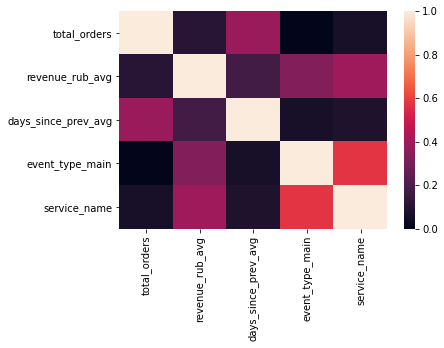

In [60]:
sns.heatmap(phik_matrix_24)

Наибольшая корреляция с количеством дней между покупками

<AxesSubplot:>

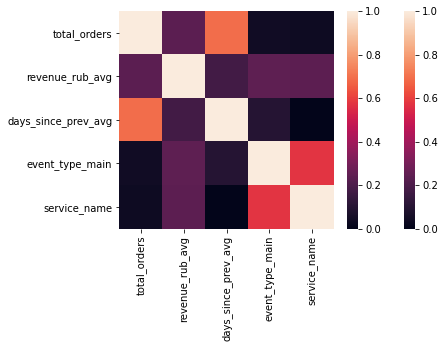

In [59]:
sns.heatmap(phik_matrix_5)

Наибольшая корреляция с количеством дней между покупками

### 5. Общий вывод и рекомендации

В конце проекта напишите общий вывод и рекомендации: расскажите заказчику, на что нужно обратить внимание. В выводах кратко укажите:

- **Информацию о данных**, с которыми вы работали, и то, как они были подготовлены: например, расскажите о фильтрации данных, переводе тенге в рубли, фильтрации выбросов.
- **Основные результаты анализа.** Например, укажите:
    - Сколько пользователей в выборке? Как распределены пользователи по числу заказов? Какие ещё статистические показатели вы подсчитали важным во время изучения данных?
    - Какие признаки первого заказа связаны с возвратом пользователей?
    - Как связаны средняя выручка и количество билетов в заказе с вероятностью повторных покупок?
    - Какие временные характеристики влияют на удержание (день недели, интервалы между покупками)?
    - Какие характеристики первого заказа и профиля пользователя могут быть связаны с числом покупок согласно результатам корреляционного анализа?
- Дополните выводы информацией, которая покажется вам важной и интересной. Следите за общим объёмом выводов — они должны быть компактными и ёмкими.

В конце предложите заказчику рекомендации о том, как именно действовать в его ситуации. Например, укажите, на какие сегменты пользователей стоит обратить внимание в первую очередь, а какие нуждаются в дополнительных маркетинговых усилиях.

Выручка была приведина к рублям.
Показатели выручки и количество заказов были отфильтрованы по 99 процентилю.

Всего представленно 21000 пользователей в изначалбном массиве и 13000 в агрегированном.
Большинство делают 2-3 заказа. Заказы делаются на суммы от 100 до 500 рублей. 60 процентов пользователей сделали повторный заказ. Средний промежуток между покупками 14 дней.

Пользователи тратят значительно меньше денег н апервый заказ.
Больше всего покупок происходит в воскресенье. День недели не влияет на вероятность повторного заказа.

Самый выделяющийся показатель это среднее количество дней после покупки.

### 6. Финализация проекта и публикация в Git

Когда вы закончите анализировать данные, оформите проект, а затем опубликуйте его.

Выполните следующие действия:

1. Создайте файл `.gitignore`. Добавьте в него все временные и чувствительные файлы, которые не должны попасть в репозиторий.
2. Сформируйте файл `requirements.txt`. Зафиксируйте все библиотеки, которые вы использовали в проекте.
3. Вынести все чувствительные данные (параметры подключения к базе) в `.env`файл.
4. Проверьте, что проект запускается и воспроизводим.
5. Загрузите проект в публичный репозиторий — например, на GitHub. Убедитесь, что все нужные файлы находятся в репозитории, исключая те, что в `.gitignore`. Ссылка на репозиторий понадобится для отправки проекта на проверку. Вставьте её в шаблон проекта в тетрадке Jupyter Notebook перед отправкой проекта на ревью.

**Вставьте ссылку на проект в этой ячейке тетрадки перед отправкой проекта на ревью.**